In [5]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot(results_dir, graphs=False, confusion_matrix=False):
    data_list = []

    # Loop through each file in the directory
    for filename in os.listdir(results_dir):
        if filename.endswith('.json'):
            # Load the data from the JSON file
            with open(os.path.join(results_dir, filename), 'r') as file:
                data = json.load(file)

            model_id = data['model_id']
            train_acc_list = data.get('train_accuracy', None)
            train_loss_list = data.get('train_loss', None)
            val_acc_list = data.get('val_accuracy', None)
            val_loss_list = data.get('val_loss', None)
            best_val_acc = data['results'].get('best_acc', None)
            best_epoch = data['results'].get('best_acc_epoch', None)
            cm = np.array(data['results'].get('confusion_matrix', [])) if 'confusion_matrix' in data['results'] else None

            # Extract hyperparameters if available, otherwise set as None
            lr = data['hyperparameters'].get('learning_rate', None)
            epochs = data['hyperparameters'].get('num_epochs', None)
            batch_size = data['hyperparameters'].get('batch_size', None)
            max_len = data['hyperparameters'].get('max_len', None)
            

            row_data = {
                'model_id': model_id,
                'learning_rate': lr,
                'num_epochs': epochs,
                'batch_size': batch_size,
                'max_len': max_len,
                'best_epoch':best_epoch,
                'best_val_accuracy': best_val_acc,
            }

            data_list.append(row_data)
            if confusion_matrix:
                # Plot the confusion matrix
                disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                disp.plot()
                plt.title(f'Confusion Matrix for Model {model_id}')
                plt.show()

                # Print the classification report
                report = data['results']['classification_report']
                print(f'Classification Report for Model {model_id}:')
                print(report)

            if graphs:            
                fig, ax = plt.subplots()
                ax.plot(train_acc_list, label='Training Accuracy')
                ax.plot(val_acc_list, label='Validation Accuracy')
                ax.set_xlabel('Epoch')
                ax.set_ylabel('Accuracy')
                ax.set_title(f'Accuracy for lr {lr}, batch size {batch_size}, max len {max_len}, best ac: {best_val_acc:.2f}')
                ax.legend()
                ax.set_ylim(0, 1)  # Set y-axis limits from 0 to 1 for accuracy

                # Add faint grid
                ax.set_axisbelow(True)
                ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)
                # Display best accuracy in a box on the graph
                best_acc_text = f'Best Accuracy: {best_val_acc:.2f}'
                plt.text(0.05, 0.95, best_acc_text, transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

                # Plot the training and validation loss
                plt.figure()
                plt.plot(train_loss_list, label='Training Loss')
                plt.plot(val_loss_list, label='Validation Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title(f'Loss for Model {model_id}')
                plt.legend()
                plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)  # Add faint grid
                plt.ylim(0, 1)  # Set y-axis limits from 0 to 1 for accuracy
                plt.tight_layout()
                plt.show()
                
    df = pd.DataFrame(data_list)
    df.set_index('model_id', inplace=True)
    
    def highlight_max(s):
        is_max = s == s.max()
        return ['background-color: yellow' if v else '' for v in is_max]

    styled_df = df.style.apply(highlight_max, subset=['best_val_accuracy'])
    return styled_df


In [6]:
bert_bin = './results/bert_binary'
bert_multi = './results/bert_multi'

bert_seq_bin = './results/bert4seq_binary'
bert_seq_mult = './results/bert4seq_multi'

w2v_bin = './results/w2v_binary'
w2v_seq = './results/w2v_multi'

In [11]:
plot(bert_bin,graphs=False, confusion_matrix=False)

,learning_rate,num_epochs,batch_size,max_len,best_epoch,best_val_accuracy
model_id,,,,,,
f4d6adf0-1def-4605-b5bf-49b731660fc3,0.000005,24,50,150,17,0.839063
119e526c-c646-43ed-a272-348f730e81af,0.000001,40,80,150,37,0.784375
54187875-8297-4c6f-98d8-00537301bc38,0.000000,40,80,150,37,0.745313
354aca28-406f-41da-8465-69b55d6dcd8b,0.000000,60,80,150,57,0.773438
c0887bc9-6387-4643-b0e4-bff6ba08afe9,0.000005,24,80,150,18,0.768750
97fd9ca1-e6ec-4090-acd6-e40911ff687c,0.000050,24,80,150,7,0.800000
b1d59ff0-5297-44b4-a60b-2b9c6704cd39,0.000001,24,50,150,22,0.795312
8d3481ec-85aa-41ea-9174-be8bc42fb5a5,0.000010,24,80,150,17,0.784375


In [12]:
plot(bert_multi, graphs=False, confusion_matrix=False)

,learning_rate,num_epochs,batch_size,max_len,best_epoch,best_val_accuracy
model_id,,,,,,
08840e67-c4cd-46a0-9f9a-aab6a7275813,0.000005,35,25,150,28,0.640777
5e6b1a3c-b12c-4d06-87ef-a90eae819ee4,0.000010,35,25,150,34,0.669903
ccb211a9-0347-40b8-b7da-b4c325af7a6d,0.000001,60,25,150,54,0.592233
8fe23a85-c5f4-4934-8f0a-ffe324d7fdf5,0.000050,35,25,150,32,0.650485
f0d84600-64be-4066-bb19-d4edbcca443e,0.000001,35,25,150,34,0.446602


In [13]:
plot(bert_seq_bin, graphs=False, confusion_matrix=False)

,learning_rate,num_epochs,batch_size,max_len,best_epoch,best_val_accuracy
model_id,,,,,,
d77612be-cd36-49f2-8e66-42ed304d454d,0.000010,10,50,150,8,0.785937
988bcbc7-72ce-400a-9e55-248f2a1b09bf,0.000001,20,50,150,15,0.787500
64146dd1-22c1-4c32-8eab-7e7a3f8a1196,0.000001,10,80,150,9,0.709375
fb735898-e4d9-43c3-ada6-76a6ef276f7b,0.000005,10,50,150,5,0.784375
42008382-f62d-4129-a8fe-5ac18f4ba56d,0.000005,20,50,150,15,0.790625


In [14]:
plot(bert_seq_mult, graphs=False, confusion_matrix=False)

,learning_rate,num_epochs,batch_size,max_len,best_epoch,best_val_accuracy
model_id,,,,,,
84d946fd-72d9-4073-bcb3-19120a7ecb7c,0.000010,25,25,150,13,0.653722
44392080-54c0-4981-8466-c2fbc376eff3,0.000001,25,25,150,24,0.417476
3cbf0e25-c54d-4329-9d04-d018c9261647,0.000005,25,25,150,20,0.660194
e0fab39b-7665-46a6-9a8b-9fb3607a780f,0.000001,60,25,150,54,0.605178


In [15]:
plot(w2v_bin, graphs=False, confusion_matrix=False)

,learning_rate,num_epochs,batch_size,max_len,best_epoch,best_val_accuracy
model_id,,,,,,
b3195fb4-13c1-4445-8ea5-8786d6193062,0.000500,100,120,None,37,0.746875
d4c9d1fd-91ff-4ea8-8057-48121b0a60d2,0.000500,100,100,None,7,0.746875
596355dd-9293-4ecc-89eb-e04d67b701b0,0.000500,100,20,None,44,0.745313
735a772b-2380-46c5-b799-bf8175fd8a4f,0.000500,100,100,None,77,0.748437
7e48c2fb-4697-4853-a4b0-bcba7d1010fb,0.000010,100,100,None,82,0.693750
da40269a-d34c-406d-a390-11706c844562,0.000500,100,80,None,28,0.750000
a6d25cd8-4a7d-47e1-92bf-83427f357a20,0.000500,100,100,None,10,0.750000
8cc356d9-0d29-4c0d-80c1-dc5991d35620,0.000500,100,100,None,32,0.748437
177e7e8c-56ec-4c20-83df-c66cd78c7d85,0.000050,100,100,None,80,0.739062


In [16]:
plot(w2v_seq, graphs=False, confusion_matrix=False)

,learning_rate,num_epochs,batch_size,max_len,best_epoch,best_val_accuracy
model_id,,,,,,
f5499e87-c02b-4378-9ae7-9347cc4472d8,0.000500,100,8,None,53,0.546926
c82e4b9e-9a21-4beb-acc1-64c43b759ffd,0.000500,100,50,None,95,0.359223
a13e8cb2-d226-4f79-b9f2-5ac07a3c57b4,0.000500,100,100,None,44,0.543689
33328f59-6efb-4ba1-90c9-5a0a44d9bba2,0.000500,100,165,None,21,0.514563
57d01f8f-12c0-4f47-b615-82a78933125c,0.000500,100,100,None,20,0.478964
9e087e53-103e-4bc1-a8b8-0e6ed94136cf,0.000100,100,50,None,98,0.524272
8e3a50c5-1f8c-44f3-bc89-53275499a176,0.001000,100,50,None,18,0.537217
3bde1f79-6e1c-4f97-9d59-00fe70be10b8,0.000500,100,50,None,56,0.540453
cf560c52-1fe6-49a9-ae84-69fc91e533aa,0.000500,100,50,None,29,0.540453


In [25]:
import os
import json
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def compile_best_results(results_dir, graph=False, confusion_matrix=False):
    data = []

    # Loop through the subdirectories in the 'results' directory
    for subdir in os.listdir(results_dir):
        subdir_path = os.path.join(results_dir, subdir)
        
        # Check if the current item is a directory
        if os.path.isdir(subdir_path):
            best_acc = 0
            best_file = None
            
            # Loop through the JSON files in the subdirectory
            for file in os.listdir(subdir_path):
                if file.endswith(".json"):
                    file_path = os.path.join(subdir_path, file)
                    
                    # Load the JSON data
                    with open(file_path) as f:
                        json_data = json.load(f)
                    
                    # Check if the JSON has the 'results' key
                    if 'results' in json_data:
                        results = json_data['results']
                        
                        # Check if the 'best_acc' key exists and update the best accuracy
                        if 'best_acc' in results and results['best_acc'] > best_acc:
                            best_acc = results['best_acc']
                            best_file = file_path
            
            # If a best file was found, add its data to the list
            if best_file:
                with open(best_file) as f:
                    best_data = json.load(f)
                
                # Extract relevant information from the best-performing model
                model_id = best_data['model_id']
                best_epoch = best_data['results'].get('best_acc_epoch', None)
                
                # Extract hyperparameters if available, otherwise set as None
                lr = best_data['hyperparameters'].get('learning_rate', None)
                epochs = best_data['hyperparameters'].get('num_epochs', None)
                batch_size = best_data['hyperparameters'].get('batch_size', None)
                max_len = best_data['hyperparameters'].get('max_len', None)
                
                # Extract additional information for graphs and confusion matrix
                train_acc_list = best_data.get('train_accuracy', None)
                train_loss_list = best_data.get('train_loss', None)
                val_acc_list = best_data.get('val_accuracy', None)
                val_loss_list = best_data.get('val_loss', None)
                cm = np.array(best_data['results'].get('confusion_matrix', [])) if 'confusion_matrix' in best_data['results'] else None
                
                # Create a dictionary with the extracted information
                row_data = {
                    'model_id': model_id,
                    'subdir': subdir,
                    'learning_rate': lr,
                    'num_epochs': epochs,
                    'batch_size': batch_size,
                    'max_len': max_len,
                    'best_epoch': best_epoch,
                    'best_val_accuracy': best_acc
                }
                
                data.append(row_data)
                
                if confusion_matrix and cm is not None:
                    # Plot the confusion matrix
                    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                    disp.plot()
                    plt.title(f'Confusion Matrix for Model {model_id}')
                    plt.show()
                    
                    # Print the classification report
                    report = best_data['results'].get('classification_report', None)
                    if report:
                        print(f'Classification Report for Model {model_id}:')
                        print(report)
                
                if graph and train_acc_list and val_acc_list and train_loss_list and val_loss_list:
                    fig, ax = plt.subplots()
                    ax.plot(train_acc_list, label='Training Accuracy')
                    ax.plot(val_acc_list, label='Validation Accuracy')
                    ax.set_xlabel('Epoch')
                    ax.set_ylabel('Accuracy')
                    ax.set_title(f'Accuracy for lr {lr}, batch size {batch_size}, max len {max_len}, best acc: {best_acc:.2f}')
                    ax.legend()
                    ax.set_ylim(0, 1)  # Set y-axis limits from 0 to 1 for accuracy

                    # Add faint grid
                    ax.set_axisbelow(True)
                    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)
                    # Display best accuracy in a box on the graph
                    best_acc_text = f'Best Accuracy: {best_acc:.2f}'
                    plt.text(0.05, 0.95, best_acc_text, transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

                    # # Plot the training and validation loss
                    # plt.figure()
                    # plt.plot(train_loss_list, label='Training Loss')
                    # plt.plot(val_loss_list, label='Validation Loss')
                    # plt.xlabel('Epoch')
                    # plt.ylabel('Loss')
                    # plt.title(f'Loss for Model {model_id}')
                    # plt.legend()
                    # plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)  # Add faint grid
                    # plt.ylim(0, 1)  # Set y-axis limits from 0 to 1 for accuracy
                    plt.tight_layout()
                    plt.show()
    
    # Create a DataFrame from the compiled data
    df = pd.DataFrame(data)
    df.set_index('model_id', inplace=True)
    
    # Sort the DataFrame by 'best_val_accuracy' in descending order
    df.sort_values(by='best_val_accuracy', ascending=False, inplace=True)
    
    return df

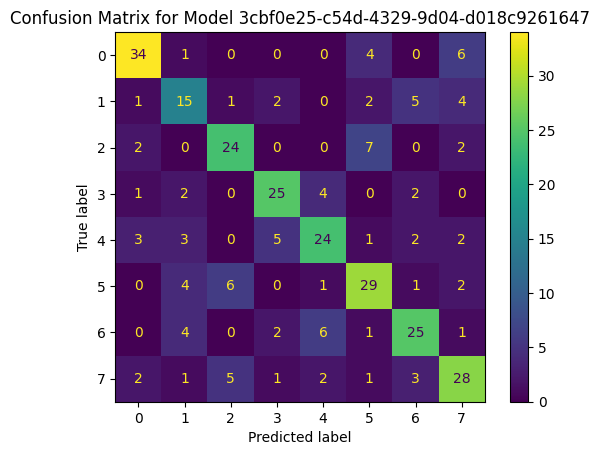

Classification Report for Model 3cbf0e25-c54d-4329-9d04-d018c9261647:
                           precision    recall  f1-score   support

              flag_waving       0.79      0.76      0.77        45
exaggeration,minimisation       0.50      0.50      0.50        30
causal_oversimplification       0.67      0.69      0.68        35
    name_calling,labeling       0.71      0.74      0.72        34
               repetition       0.65      0.60      0.62        40
                    doubt       0.64      0.67      0.66        43
          loaded_language       0.66      0.64      0.65        39
 appeal_to_fear_prejudice       0.62      0.65      0.64        43

                 accuracy                           0.66       309
                macro avg       0.66      0.66      0.66       309
             weighted avg       0.66      0.66      0.66       309



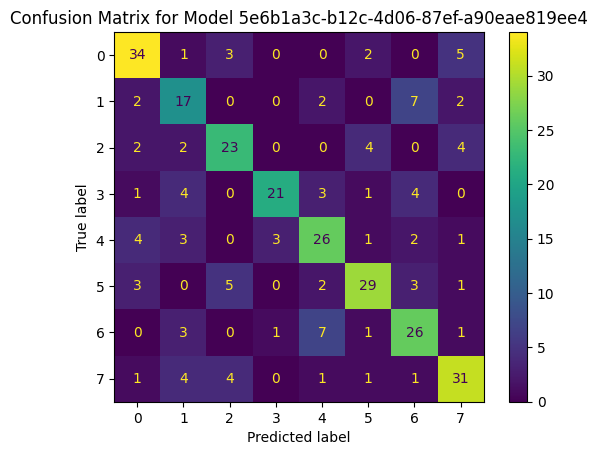

Classification Report for Model 5e6b1a3c-b12c-4d06-87ef-a90eae819ee4:
                           precision    recall  f1-score   support

              flag_waving       0.72      0.76      0.74        45
exaggeration,minimisation       0.50      0.57      0.53        30
causal_oversimplification       0.66      0.66      0.66        35
    name_calling,labeling       0.84      0.62      0.71        34
               repetition       0.63      0.65      0.64        40
                    doubt       0.74      0.67      0.71        43
          loaded_language       0.60      0.67      0.63        39
 appeal_to_fear_prejudice       0.69      0.72      0.70        43

                 accuracy                           0.67       309
                macro avg       0.67      0.66      0.67       309
             weighted avg       0.68      0.67      0.67       309



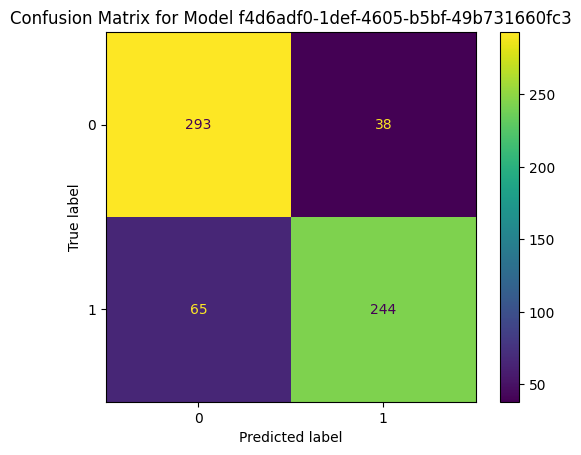

Classification Report for Model f4d6adf0-1def-4605-b5bf-49b731660fc3:
              precision    recall  f1-score   support

     Class 0       0.84      0.84      0.84       331
     Class 1       0.83      0.83      0.83       309

    accuracy                           0.84       640
   macro avg       0.84      0.84      0.84       640
weighted avg       0.84      0.84      0.84       640



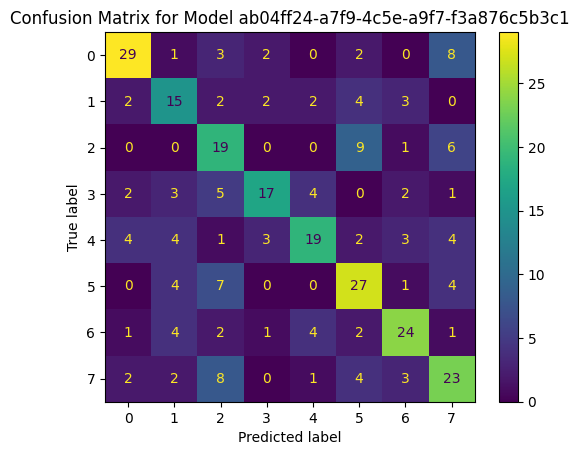

Classification Report for Model ab04ff24-a7f9-4c5e-a9f7-f3a876c5b3c1:
                           precision    recall  f1-score   support

              flag_waving       0.72      0.64      0.68        45
exaggeration,minimisation       0.45      0.50      0.48        30
causal_oversimplification       0.40      0.54      0.46        35
    name_calling,labeling       0.68      0.50      0.58        34
               repetition       0.63      0.47      0.54        40
                    doubt       0.54      0.63      0.58        43
          loaded_language       0.65      0.62      0.63        39
 appeal_to_fear_prejudice       0.49      0.53      0.51        43

                 accuracy                           0.56       309
                macro avg       0.57      0.56      0.56       309
             weighted avg       0.58      0.56      0.56       309



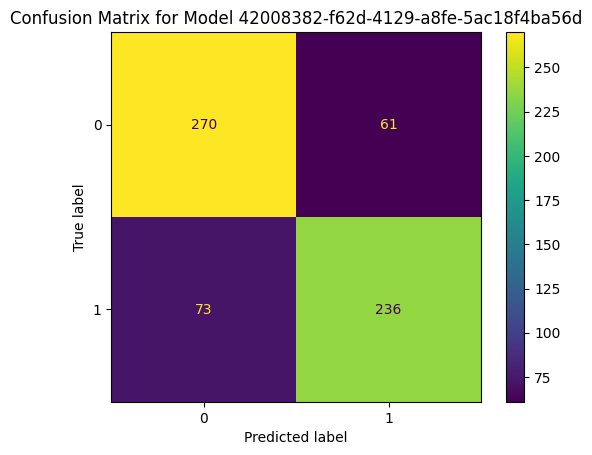

Classification Report for Model 42008382-f62d-4129-a8fe-5ac18f4ba56d:
              precision    recall  f1-score   support

     Class 0       0.80      0.77      0.79       331
     Class 1       0.76      0.80      0.78       309

    accuracy                           0.78       640
   macro avg       0.78      0.78      0.78       640
weighted avg       0.78      0.78      0.78       640



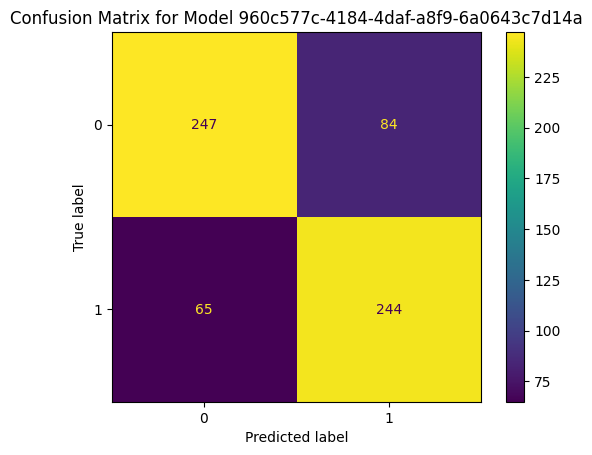

Classification Report for Model 960c577c-4184-4daf-a8f9-6a0643c7d14a:
              precision    recall  f1-score   support

     class 0       0.79      0.75      0.77       331
     class 1       0.74      0.79      0.77       309

    accuracy                           0.77       640
   macro avg       0.77      0.77      0.77       640
weighted avg       0.77      0.77      0.77       640



,subdir,learning_rate,num_epochs,batch_size,max_len,best_epoch,best_val_accuracy
model_id,,,,,,,
f4d6adf0-1def-4605-b5bf-49b731660fc3,bert_binary,0.000005,24,50,150.0,17,0.839063
42008382-f62d-4129-a8fe-5ac18f4ba56d,bert4seq_binary,0.000005,20,50,150.0,15,0.790625
960c577c-4184-4daf-a8f9-6a0643c7d14a,w2v_binary,0.000050,100,100,NaN,54,0.767188
5e6b1a3c-b12c-4d06-87ef-a90eae819ee4,bert_multi,0.000010,35,25,150.0,34,0.669903
3cbf0e25-c54d-4329-9d04-d018c9261647,bert4seq_multi,0.000005,25,25,150.0,20,0.660194
ab04ff24-a7f9-4c5e-a9f7-f3a876c5b3c1,w2v_multi,0.000500,100,128,NaN,91,0.559871


In [27]:
compile_best_results('./results', graph=False, confusion_matrix=True)